# Profiler demo

This is a demo of the `Profiler` class.
It allows to attach to the most common Python/PyTorch objects and measure their execution times.

### Known limitations
* some PyTorch modules are called multiple times during inference, e.g. activation functions. Currently, the profiler doesn't distinguish between them and treat them the same. This might be enough for some applications, but for the others it might lead to false conclusions. For instance, if the same activation function is applied on outputs of different size, its timings should naturally be different.

## Setup

In [14]:
!pip install numpy torch torchvision pillow

In [15]:
!wget --no-check-certificate -O 'data.zip' 'https://docs.google.com/uc?export=download&id=1VIRCVaKMNGA2Ty3yzCd_qWhJP_9tvxZI'
!unzip -o data.zip

--2024-05-02 20:49:26--  https://docs.google.com/uc?export=download&id=1VIRCVaKMNGA2Ty3yzCd_qWhJP_9tvxZI
Resolving docs.google.com (docs.google.com)... 142.251.209.142
Connecting to docs.google.com (docs.google.com)|142.251.209.142|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1VIRCVaKMNGA2Ty3yzCd_qWhJP_9tvxZI&export=download [following]
--2024-05-02 20:49:27--  https://drive.usercontent.google.com/download?id=1VIRCVaKMNGA2Ty3yzCd_qWhJP_9tvxZI&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.181.193
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.181.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 718341 (702K) [application/octet-stream]
Saving to: ‘data.zip’

data.zip            100%[===================>] 701.50K  --.-KB/s    in 0.1s    

2024-05-02 20:49:28 (5.09 MB/s) - ‘data.zip’ saved [

## `Profiler` class

In [16]:
import inspect
import time
from collections import defaultdict
from functools import wraps
from typing import Any, Callable

import torch
import torch.nn as nn
from torchvision import transforms

_ProfileCondition = Callable[[Callable], bool]
_ProfileFn = Callable[[object, Callable, str], Callable]


def _is_nn_module(obj: Callable) -> bool:
    return isinstance(obj, nn.Module)


def _is_transforms_compose(obj: Callable) -> bool:
    return isinstance(obj, transforms.Compose)


def _is_callable_object(obj: Callable) -> bool:
    return inspect.ismethod(getattr(obj, "__call__", None))


def _is_function(obj: Callable) -> bool:
    return inspect.isfunction(obj)


def _measure_cpu(fn: Callable, *args, **kwargs) -> tuple[Any, float]:
    start = time.perf_counter_ns()
    out = fn(*args, **kwargs)
    end = time.perf_counter_ns()
    delta = (end - start) / 1000 / 1000  # [ns] -> [ms]
    return out, delta


def _measure_cuda(fn: Callable, *args, **kwargs) -> tuple[Any, float]:
    """
    Probably, `time.perf_counter_ns()` should be just fine.
    The most important thing is to synchronize processes.
    """
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    torch.cuda.synchronize()
    start.record()
    out = fn(*args, **kwargs)
    end.record()
    torch.cuda.synchronize()
    delta = start.elapsed_time(end)  # [ms]
    return out, delta


class Profiler:
    def __init__(self):
        self._values = defaultdict(list)

    def profile(self, obj: Callable, name: str):
        for condition, fn in self._dispatcher:
            if condition(obj):
                return fn(self, obj, name)

        raise ValueError("Cannot profile this object")

    def data(self) -> dict:
        return self._values

    def clear(self):
        self._values.clear()

    def _instrument_module(
        self,
        module: nn.Module,
        prefix: str = "",
        prev_device: torch.device | None = None,
    ):
        if not isinstance(module, nn.Module):
            raise ValueError("You must pass an `nn.Module` object")

        this_device = self._get_module_device(module)
        if this_device is None:
            this_device = prev_device

        if this_device.type == "cuda":
            self._attach_module_cuda_instrumentation(module, prefix)
        else:
            self._attach_module_cpu_instrumentation(module, prefix)

        for child_name, child in module.named_children():
            self._instrument_module(child, f"{prefix}.{child_name}", this_device)

    def _attach_module_cpu_instrumentation(self, obj: nn.Module, name: str):
        forward_orig = obj.forward

        @wraps(forward_orig)
        def wrapper(*args, **kwargs):
            out, delta = _measure_cpu(forward_orig, *args, **kwargs)
            self._values[name].append(delta)
            return out

        obj.forward = wrapper

    def _attach_module_cuda_instrumentation(self, obj: nn.Module, name: str):
        forward_orig = obj.forward

        @wraps(forward_orig)
        def wrapper(*args, **kwargs):
            out, delta = _measure_cuda(forward_orig, *args, **kwargs)
            self._values[name].append(delta)
            return out

        obj.forward = wrapper

    def _get_module_device(self, module: nn.Module) -> torch.device | None:
        try:
            return next(module.parameters()).device
        except StopIteration:
            # Module has no parameters
            return None

    def _instrument_transforms_compose(self, compose: transforms.Compose, name: str):
        self._instrument_callable_object(compose, name)

        for i, child in enumerate(compose.transforms):
            if isinstance(child, nn.Module):
                self._instrument_module(child, f"{name}[{i}]", torch.device("cpu"))
            else:
                self._instrument_callable_object(child, f"{name}[{i}]")

    def _instrument_callable_object(self, obj: Callable, name: str):
        call_orig = obj.__class__.__call__
        call = self._instrument_function(call_orig, name)
        obj.__class__.__call__ = call

    def _instrument_function(self, obj: Callable, name: str) -> Callable:
        @wraps(obj)
        def wrapper(*args, **kwargs):
            out, delta = _measure_cpu(obj, *args, **kwargs)
            self._values[name].append(delta)
            return out

        return wrapper

    # Register more handlers here
    _dispatcher: list[tuple[_ProfileCondition, _ProfileFn]] = [
        (_is_nn_module, _instrument_module),
        (_is_transforms_compose, _instrument_transforms_compose),
        (_is_callable_object, _instrument_callable_object),
        (_is_function, _instrument_function),
    ]


## Usage

In [17]:
from functools import partial
from pprint import pprint

from PIL import Image, ImageDraw
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.models.detection import retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights

In [18]:
device = "cpu"

In [19]:
prof = Profiler()

In [20]:
model = retinanet_resnet50_fpn_v2(weights=RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT)
model = model.to(device)
model.eval()

prof.profile(model, "model")


In [21]:
input_transforms = transforms.Compose([
    RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT.transforms(),
    transforms.RandomResizedCrop(512, scale=(0.9, 1.0)),
])

prof.profile(input_transforms, "preprocess")


In [22]:
dataset = datasets.ImageFolder("./data", transform=input_transforms)
data_loader = DataLoader(dataset, batch_size=1)

In [23]:
@partial(prof.profile, name="postprocess.convert_detections")
def convert_detections(out: dict) -> list[tuple[int, int, int, int]]:
    valid_idx = out["scores"] > 0.3
    bboxes = out["boxes"][valid_idx]
    bboxes = bboxes.cpu().numpy().astype(int).tolist()
    return bboxes


@partial(prof.profile, name="postprocess.decode_image")
def decode_image(image: torch.Tensor) -> Image.Image:
    return transforms.ToPILImage()(image)


@partial(prof.profile, name="postprocess.plot_bboxes")
def plot_bboxes(image: Image.Image, bboxes: list[tuple[int, int, int, int]]) -> Image.Image:
    out = image.copy()
    draw = ImageDraw.Draw(out)
    for bbox in bboxes:
        draw.rectangle(bbox)
    return out

In [24]:
results = []
with torch.no_grad():
    # Warmup
    for img, _ in data_loader:
        img = img.to(device)
        model(img)

    prof.clear()

    # Benchmark
    for img, _ in data_loader:
        img = img.to(device)
        out = model(img)[0]
        detections = convert_detections(out)
        img_pil = decode_image(img[0])
        final = plot_bboxes(img_pil, detections)
        results.append(final)

In [25]:
pprint(prof.data())

defaultdict(<class 'list'>,
            {'model': [543.184375,
                       485.01295799999997,
                       465.81966700000004,
                       471.689333,
                       519.943667],
             'model.anchor_generator': [0.857208,
                                        0.606125,
                                        0.6571670000000001,
                                        0.624792,
                                        1.487042],
             'model.backbone': [291.008333,
                                241.09995800000002,
                                237.605125,
                                237.440792,
                                262.284167],
             'model.backbone.body': [256.79075,
                                     212.60916699999999,
                                     210.177042,
                                     208.5935,
                                     231.485125],
             'model.backbone.body.bn1':

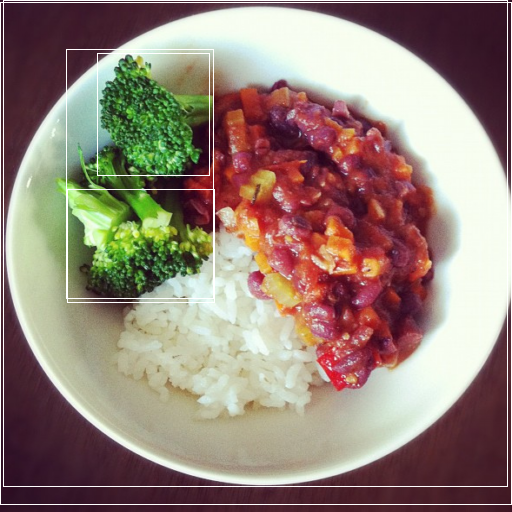

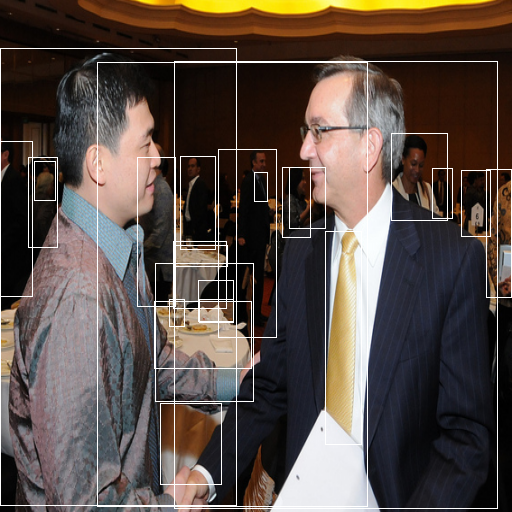

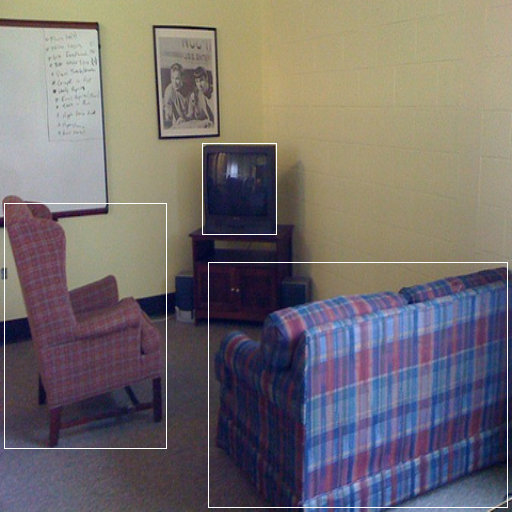

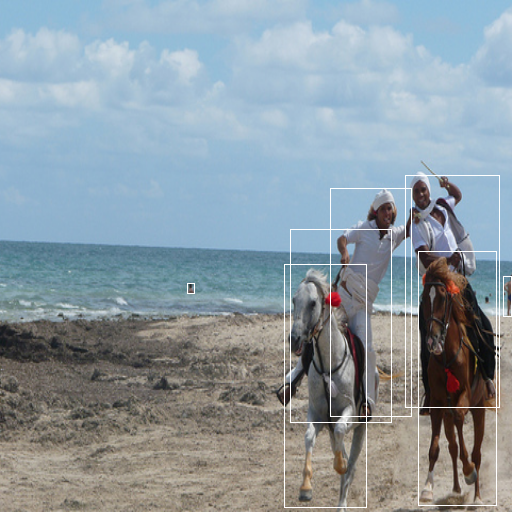

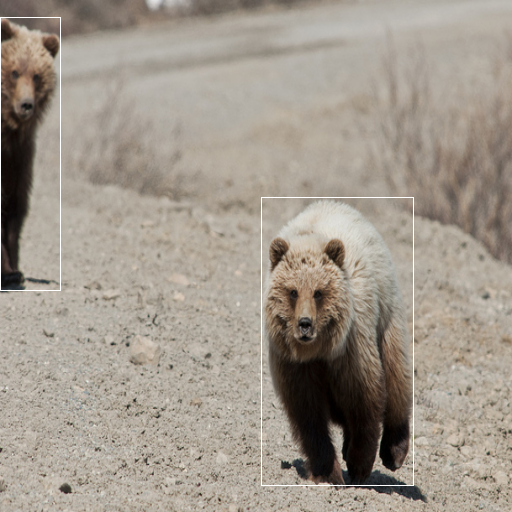

In [26]:
display(*results)
